# Controllability

In [4]:
import os
import argparse
import shutil
import numpy as np
import imageio
from itertools import chain
import torch
import sys
import matplotlib.pyplot as plt
sys.path.insert(0, "../../SemanticStyleGAN")
from models import make_model
from visualize.utils import generate, cubic_spline_interpolate
from utils.control import Control
from numpy import array
from numpy import mean
from numpy import cov 
from numpy.linalg import eig
from torch import nn
import torch
from pathlib import Path



In [2]:
def calculate_sefa(model,local_nets,layers,take_conv_weights=True):
    '''
    Function to get certain weights out of the SSG Model.
    local_nets between 0 and 15
    layers between 0 and 9
    '''
    all_local_nets=model.__getattr__("local_nets")
    weights = []
    if not type(layers)==list:
        layers=[layers]
    for l_net in local_nets:
        for layer in layers:
            weight_temp_conv=all_local_nets[l_net].__getattr__("linears")[layer].__getattr__("conv").weight.squeeze(0)
            weight_temp_modulation=all_local_nets[l_net].__getattr__("linears")[layer].__getattr__("conv").__getattr__("modulation").weight
            weight_temp_conv = weight_temp_conv.flip(2, 3).permute(1, 0, 2, 3).flatten(1)
            if take_conv_weights:
                 weights.append(weight_temp_conv.cpu().detach().numpy())
            else:
                 weights.append(weight_temp_modulation.cpu().detach().numpy())
    weight = np.concatenate(weights, axis=1).astype(np.float32)
    weight = weight / np.linalg.norm(weight, axis=0, keepdims=True)
    eigen_values, eigen_vectors = np.linalg.eig(weight.dot(weight.T))

    return eigen_vectors.T,eigen_values

#### Intialize control and load latents

In [15]:
ckpt="/usr/stud/faragy/storage/user/data/checkpoints/SSG_v3.13/ckpt/140000.pt"
#ckpt = "/usr/stud/faragy/storage/user/data/checkpoints/mapillary_v1/250000.pt"
device="cpu"
control = Control(ckpt,device)

Loading model ...
Initializing model with arguments:
{'aug': False,
 'base_layers': 2,
 'batch': 4,
 'channel_multiplier': 2,
 'checkpoint_dir': '/no_backups/g013/checkpoints/SSG_v3.13',
 'ckpt': None,
 'coarse_channel': 512,
 'coarse_size': 64,
 'd_reg_every': 16,
 'dataset': '/no_backups/g013/data/lmdb_datasets/lmdb_v3.3',
 'depth_layers': 6,
 'detach_texture': False,
 'distributed': True,
 'g_reg_every': 4,
 'inception': '/no_backups/g013/data/inception_models/inception_v3.3.pkl',
 'iter': 600001,
 'lambda_mask': 100.0,
 'latent': 512,
 'local_channel': 64,
 'local_layers': 10,
 'local_rank': 0,
 'lr': 0.002,
 'min_feat_size': 16,
 'mixing': 0.3,
 'n_gpu': 4,
 'n_mlp': 8,
 'n_sample': 16,
 'num_workers': 8,
 'path_batch_shrink': 2,
 'path_regularize': 0.5,
 'r1_img': 10,
 'r1_seg': 1000,
 'residual_refine': True,
 'save_every': 5000,
 'seg_dim': 16,
 'size': 256,
 'start_iter': 0,
 'transparent_dims': (10, 12),
 'viz_every': 2000}


In [16]:
#Styles for Cityscape
latent1= "../results/saved_samples/first_latent.npy"
latent2= "../results/saved_samples/second_latent.npy"
latent3= "../results/saved_samples/third_latent.npy"
latent4="../results/saved_samples/fourth_latent.npy"
latent5="../results/saved_samples/fifth_latent.npy"
latent6="../results/saved_samples/sixth_latent.npy"
latent7="../results/saved_samples/seventh_latent.npy"
latent_mean="../results/saved_samples/mean_latent.npy"
table_2_input = "../results/saved_samples/table_2_input.npy"
styles1 = torch.tensor(np.load(latent1), device=device)
styles2 = torch.tensor(np.load(latent2), device=device)
styles3 = torch.tensor(np.load(latent3), device=device)
styles4 = torch.tensor(np.load(latent4), device=device)
styles5 = torch.tensor(np.load(latent5), device=device)
styles6 = torch.tensor(np.load(latent6), device=device)
styles7 = torch.tensor(np.load(latent7), device=device)
styles_mean = torch.tensor(np.load(latent_mean), device=device)
styles_t2= torch.tensor(np.load(table_2_input), device=device)
styles1 = styles1.unsqueeze(1).repeat(1, control.model.n_latent, 1)
styles2 = styles2.unsqueeze(1).repeat(1, control.model.n_latent, 1)
styles3 = styles3.unsqueeze(1).repeat(1, control.model.n_latent, 1)
styles4 = styles4.unsqueeze(1).repeat(1, control.model.n_latent, 1)
styles5 = styles5.unsqueeze(1).repeat(1, control.model.n_latent, 1)
styles6 = styles6.unsqueeze(1).repeat(1, control.model.n_latent, 1)
styles7 = styles7.unsqueeze(1).repeat(1, control.model.n_latent, 1)
styles_mean = styles_mean.unsqueeze(1).repeat(1, control.model.n_latent, 1)
styles_t2 = styles_t2.unsqueeze(1).repeat(1, control.model.n_latent, 1)


In [4]:
# ###Styles for Mapillary
# latent1= "../results/mapillary_picked_samples/000000_latent.npy"
# latent2= "../results/mapillary_picked_samples/000003_latent.npy"
# latent3= "../results/mapillary_picked_samples/000004_latent.npy"
# latent4="../results/mapillary_picked_samples/000005_latent.npy"
# latent5="../results/mapillary_picked_samples/000007_latent.npy"
# latent6="../results/mapillary_picked_samples/000009_latent.npy"
# latent7="../results/mapillary_picked_samples/000017_latent.npy"
# latent_mean="../results/mapillary_picked_samples/mean_latent.npy"


# styles1 = torch.tensor(np.load(latent1), device=device)
# styles2 = torch.tensor(np.load(latent2), device=device)
# styles3 = torch.tensor(np.load(latent3), device=device)
# styles4 = torch.tensor(np.load(latent4), device=device)
# styles5 = torch.tensor(np.load(latent5), device=device)
# styles6 = torch.tensor(np.load(latent6), device=device)
# styles7 = torch.tensor(np.load(latent7), device=device)
# styles_mean = torch.tensor(np.load(latent_mean), device=device)

# styles1 = styles1.unsqueeze(1).repeat(1, control.model.n_latent, 1)
# styles2 = styles2.unsqueeze(1).repeat(1, control.model.n_latent, 1)
# styles3 = styles3.unsqueeze(1).repeat(1, control.model.n_latent, 1)
# styles4 = styles4.unsqueeze(1).repeat(1, control.model.n_latent, 1)
# styles5 = styles5.unsqueeze(1).repeat(1, control.model.n_latent, 1)
# styles6 = styles6.unsqueeze(1).repeat(1, control.model.n_latent, 1)
# styles7 = styles7.unsqueeze(1).repeat(1, control.model.n_latent, 1)
# styles_mean = styles_mean.unsqueeze(1).repeat(1, control.model.n_latent, 1)

#### Get and Save EigenValues

In [7]:
# ### Testing Cell just for exploration
# all_local_nets=control.model.__getattr__("local_nets")
# layer=5
# l_net=13
# weights=[]

# weight_temp_conv=all_local_nets[l_net].__getattr__("linears")[layer].__getattr__("conv").weight.squeeze(0)
# weight_temp_modulation=all_local_nets[l_net].__getattr__("linears")[layer].__getattr__("conv").__getattr__("modulation").weight
# weight_temp = weight_temp_conv.flip(2, 3).permute(1, 0, 2, 3).flatten(1)
# weights.append(weight_temp_modulation.cpu().detach().numpy())
# weight = np.concatenate(weights, axis=1).astype(np.float32)
# weight = weight / np.linalg.norm(weight, axis=0, keepdims=True)
# eigen_values, eigen_vectors = np.linalg.eig(weight.dot(weight.T))

In [23]:
weight_temp_conv.flip(2, 3).permute(1, 0, 2, 3).shape

torch.Size([64, 64, 1, 1])

In [20]:
print(all_local_nets[l_net].__getattr__("linears")[layer].__getattr__("conv").weight.flip(2,3).permute(1, 0, 2, 3).shape)

RuntimeError: number of dims don't match in permute

In [16]:
print(all_local_nets[l_net].__getattr__("linears")[layer].__getattr__("conv").__getattr__("modulation").weight.shape)

torch.Size([64, 512])


In [5]:
car_index=13
tree_index=9
road_index=1
## From 0->9 all layers
eigen_vecs,eigen_vals=calculate_sefa(control.model,[road_index],np.arange(10))
##From 2->6 shape 
eigen_vecs_shape,eigen_vals_shape=calculate_sefa(control.model,[road_index],np.arange(2,6))
##From 6->10 Texture 
eigen_vecs_texture,eigen_vals_texture=calculate_sefa(control.model,[road_index],np.arange(6,10))

## Expanding the tensor from 64x64 to 64x512
# eigen_vecs = torch.repeat_interleave(torch.tensor(eigen_vecs),8,dim=1).numpy()
# eigen_vecs_shape = torch.repeat_interleave(torch.tensor(eigen_vecs_shape),8,dim=1).numpy()
# eigen_vecs_texture = torch.repeat_interleave(torch.tensor(eigen_vecs_texture),8,dim=1).numpy()

TypeError: only integer scalar arrays can be converted to a scalar index

#### Editing Images using GAN-Space in W Space

In [5]:
## Effects of continous changing of 1 component

apply_to_all_layers=False
class_index=9
latent_index = 28
latent_name="car_shape"
component=9
coarse_layer=1
# chain_1 = range(0,0,1) # Set aside for now 
# chain_2 =  np.arange(10,-10,-0.1)
# mult_range = chain(chain_1,chain_2)
#V=eigen_vecs_shape
V=torch.load("../results/mapillary_picked_samples/principal_components_2_mapillary.pt")
"trees/cars/road/building"
classes= ["vegi_texture"]
latent_indices=[21,29,5,9]
for class_name,latent_index in zip (classes,latent_indices):
    for component in [4]:
        print(f"Processing component {component}")
        #[styles_mean,styles1,styles3]
        for i,style_chosen in enumerate([styles1,styles2,styles3,styles4,styles5,styles6,styles7,styles_mean]):
            print(f"Styles{i+1}")    
            images=[]
            segs=[]
            for multiplier in  np.linspace(60,-60,40):
                #print(f"Analyzing COMPONENT {component} with multiplier {multiplier}")
                #image,seg=control.edit_image_inject_coarse(class_index,multiplier,style_chosen,V[component],coarse_inject_layer=coarse_layer,plot=False,get_image=True)
                #latent_index = np.arange(5, 34, 2) ##For Editing all textures at once.
                image,seg=control.edit_image_principal_component(latent_index,class_index,multiplier,style_chosen,V[component],whole_image=apply_to_all_layers,plot=False,get_image=True)
                images.append(image[0])
                segs.append(seg[0])
            # images = images + images[::-1]
            # segs= segs + segs[::-1]
            control.images_to_video(images,segs,f"./data/thesis_results_mapillary/W_space_class_name_{class_name}{component}_for_image_{i+1}.mp4")

Processing component 4
Styles1


KeyboardInterrupt: 

#### Creation of a mean Image

In [13]:
styles = control.model.style(
        torch.randn(50000, control.model.style_dim, device="cpu")
    )

mean_style=styles.mean(0).unsqueeze(0)
np.save("../results/mapillary_picked_samples/mean_latent.npy",mean_style.detach().cpu().numpy())

#### Enforcing a certain class to have a higher distribution using masks

Calling modulation : torch.Size([1, 512])
Calling modulation output : torch.Size([1, 1, 64, 1, 1])
Calling modulation : torch.Size([1, 512])
Calling modulation output : torch.Size([1, 1, 64, 1, 1])
Calling modulation : torch.Size([1, 512])
Calling modulation output : torch.Size([1, 1, 64, 1, 1])
Calling modulation : torch.Size([1, 512])
Calling modulation output : torch.Size([1, 1, 64, 1, 1])
Calling modulation : torch.Size([1, 512])
Calling modulation output : torch.Size([1, 1, 64, 1, 1])
Calling modulation : torch.Size([1, 512])
Calling modulation output : torch.Size([1, 1, 64, 1, 1])
Calling modulation : torch.Size([1, 512])
Calling modulation output : torch.Size([1, 1, 64, 1, 1])
Calling modulation : torch.Size([1, 512])
Calling modulation output : torch.Size([1, 1, 64, 1, 1])
Calling modulation : torch.Size([1, 512])
Calling modulation output : torch.Size([1, 1, 64, 1, 1])
Calling modulation : torch.Size([1, 512])
Calling modulation output : torch.Size([1, 1, 64, 1, 1])
Calling mo

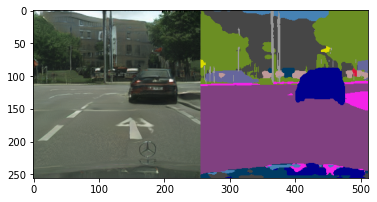

In [5]:
img,seg=control.generate_and_plot_image([styles5.squeeze(0)], 13, coords=None, plot=True, get_image=True)

The shape of the latent vector inside one LG is torch.Size([1, 10, 512])
Calling modulation : torch.Size([1, 512])
Calling modulation output : torch.Size([1, 1, 64, 1, 1])
Calling modulation : torch.Size([1, 512])
Calling modulation output : torch.Size([1, 1, 64, 1, 1])
Calling modulation : torch.Size([1, 512])
Calling modulation output : torch.Size([1, 1, 64, 1, 1])
Calling modulation : torch.Size([1, 512])
Calling modulation output : torch.Size([1, 1, 64, 1, 1])
Calling modulation : torch.Size([1, 512])
Calling modulation output : torch.Size([1, 1, 64, 1, 1])
Calling modulation : torch.Size([1, 512])
Calling modulation output : torch.Size([1, 1, 64, 1, 1])
Calling modulation : torch.Size([1, 512])
Calling modulation output : torch.Size([1, 1, 64, 1, 1])
Calling modulation : torch.Size([1, 512])
Calling modulation output : torch.Size([1, 1, 64, 1, 1])
Calling modulation : torch.Size([1, 512])
Calling modulation output : torch.Size([1, 1, 64, 1, 1])
Calling modulation : torch.Size([1, 

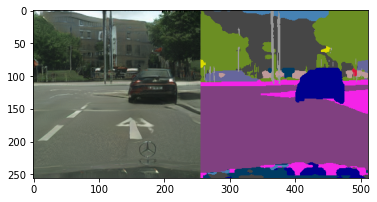

In [5]:
increased_value=0.9
base_value = 1-increased_value
mask = torch.zeros(1, 16)
mask+=base_value
mask[:,2]=base_value+increased_value*16
img,seg=control.generate_and_plot_image([styles5.squeeze(0)], 13, coords=None, plot=True, get_image=True,mask=mask)

#### Second Level Analysis

In [9]:
def convert_from_w_to_w_extended(model,w_vectors,local_generator,layer):
    '''
    A function that converts given w_vectors of size Nx512 to Nx64 given a specific demodulation in the model.
    '''
    modulation=control.model.__getattr__("local_nets")[local_generator].__getattr__("linears")[layer].__getattr__("conv").modulation
    return modulation(w_vectors)
    
def prepare_w_extended(model,style,w_extended,class_index,layers):
    assert len(style.shape)==1
    for layer_index in layers:
         w_extended[class_index][layer_index]=convert_from_w_to_w_extended(model,style,class_index,layer_index).detach()
    return w_extended

In [10]:
def calculate_pca_2(samples,selected=10):
    samples_cop = samples.cpu().detach().numpy()
    M = mean(samples_cop)
    C = samples_cop-M
    V_2=cov(C.T)
    values, vectors = eig(V_2)
    return values[:selected],vectors[:selected]

In [11]:
def calculate_pca_from_s_space(model,local_generator,layer):
    styles =model.style(
        torch.randn(50000, model.style_dim, device="cpu")
    )
    styles_converted=convert_from_w_to_w_extended(control.model,styles,local_generator,layer)
    _,vectors = calculate_pca_2(styles_converted,selected=513)
    return vectors

In [9]:
vv=calculate_pca_from_s_space(control.model,13,5)

In [1]:
##Extraction of PCA directions from the converted w extended space
truncation_mean = 10000
truncation=0.7
mean_latent =control.model.style(
    torch.randn(truncation_mean, control.model.style_dim, device="cpu")
).mean(0)

styles = control.model.style(
        torch.randn(50000, control.model.style_dim, device="cpu")
    )
##Truncation 50k styles.
#styles = truncation * styles + (1 - truncation) * mean_latent.unsqueeze(0)
local_generator=13
layer=5
styles_converted=convert_from_w_to_w_extended(control.model,styles,local_generator,layer)
res_2 = calculate_pca_2(styles_converted,selected=513)
vectors = res_2[1]



NameError: name 'control' is not defined

In [21]:
## Effects of continous changing of 1 component

apply_to_all_layers=False
latent_index=4
class_index=13
layer_index=5
layer_index=np.arange(2,6)
latent_name="car_shape"
w_extended=torch.zeros(16,10,64)

V,_=calculate_sefa(control.model,[class_index],layer_index)
for component in [6,7,8,9,10]:
    print(f"Processing component {component}")
    for i,style_chosen in enumerate([styles_mean,styles1,styles2,styles3,styles5]):
        print(f"Styles{i+1}")    
        images=[]
        segs=[]
        for multiplier in  np.linspace(-30,30,35):
            w_extended_copy = w_extended.clone().detach()
            w_extended_copy=prepare_w_extended(control.model,style_chosen[0][0],w_extended_copy,class_index,layer_index)
            w_extended_copy[class_index][layer_index]+=(multiplier*V[component])
            #print(f"Analyzing COMPONENT {component} with multiplier {multiplier}")
            image,seg= control.edit_image_inject_modulation(class_index,style_chosen,w_extended_copy,plot=False,get_image=True)
            images.append(image[0])
            segs.append(seg[0])

        control.images_to_video(images,segs,f"./data/64_v/shape_layers_sefa/for_image_{i+1}_component_{component}_class_{class_index}_layer_{layer_index}.mp4")

TypeError: only integer scalar arrays can be converted to a scalar index

#### Exploring Further why sefa is not producing good results

## Main Training and testing cell for both sefa and PCa on S space

In [26]:
    ## Effects of continous changing of 1 component

    apply_to_all_layers=False
    latent_index=4
    class_index = 1 #Road
    class_index = 13 #Car
    class_index = 9 #Vegi.
    class_index = 10 #Sky
    component=9
    coarse_layer=1
    w_extended=torch.zeros(16,10,64)
    shape_layers=[2,3,4,5]
    texture_layers=[6,7,8,9]
    #Training list of format :
    '''
    [ [Class_index,LocalGeneratorLayer, [V_components]] , ...another training param..]
    '''

    top_10_dir=[0,1,2,3,4,5,6,7,8,9]
    training_list = [[10,[5],top_10_dir],
    [10,[4],top_10_dir],
    [10,[3],top_10_dir],
    [10,[9],top_10_dir],
    [10,[8],top_10_dir],
    [10,[7],top_10_dir],]
    training_list=[[13,[5],[1,2]],
                    [13,[4],[1,2]]]
    #Training List After
    # training_list = [[13,[5],[9,10,11,12]],
    #                 [13,[4],[9,10,11,12]],
    #                 [13,[4,5],[0,1,2,3,4,5,6]],
    # ]            
    #training_list = [[13,[6,7,8,9],[0,1,2,3,4,5,6,7,8]]]

    #Mapillary related results.
    vegi_focused_styles_mp=[styles1,styles5,styles_mean]
    sky_focused_styles_mp=[styles3,styles5]
    car_focuses_styles_mp=[styles6,styles7]
    #CityScapes related res
    vegi_focused_styles_cs=[styles1,styles4,styles7]

    styles_list=[styles_mean]
    saved_pcas=[]
    #V=calculate_pca_from_s_space(control.model,class_index,layer_index)
    for training_instance in training_list:
        class_index = training_instance[0]
        layer_index= training_instance[1]
        components = training_instance[2]
        print(f"Processing class_index : {class_index}  layer index: {layer_index} with components {components}")
        #Notice that currently we are calculating weights from modulated part of the layer instead of main conv layer.
        
        
        #V,_=calculate_sefa(control.model,[class_index],layer_index,take_conv_weights=True)
        #V=calculate_pca_from_s_space(control.model,class_index,layer_index[0])
        #saved_pcas.append(V)
    
        save_path=f"./thesis_related_results/saved_numpy/layer_{layer_index[0]}_class_index_{class_index}.npy"
        
        if not os.path.exists(save_path):
            np.save(save_path,V)
        else:
            print(f"Found numpy file with the same exact directions, loading  ...")
            V = np.load(save_path)
            #raise Exception("File already exists, you sure you want to overwrite ?")
        #V_2 = np.load(f"./data/mapillary/s_space/layer_{4}_class_index_{class_index}.npy")
        for component in components:
            print(f"Processing component {component}")
            for i,style_chosen in enumerate(styles_list):
                print(f"Styles{i+1}")    
                images=[]
                segs=[]
                for multiplier in  np.linspace(-70,70,18):
                    w_extended_copy = w_extended.clone().detach()
                    w_extended_copy=prepare_w_extended(control.model,style_chosen[0][0],w_extended_copy,class_index,layer_index)
                    w_extended_copy[class_index][layer_index[0]]+=((multiplier)*V[component])
                    #w_extended_copy[class_index][4]+=((multiplier)*V_2[1])
                    ##For Double EFFECT !!!! Remove !!!
                    #print(f"Analyzing COMPONENT {component} with multiplier {multiplier}")
                    image,seg= control.edit_image_inject_modulation(class_index,style_chosen,w_extended_copy,plot=False,get_image=True)
                    images.append(image[0])
                    segs.append(seg[0])
                control.images_to_video(images,segs,f"./thesis_related_results/table_2/retake/s_gan_space_layer_{layer_index}_{component}_component_for_image_{i+1}__class_{class_index}_xxxx.mp4")
                #control.images_to_video(images,segs,f"./data/mapillary/s_space/class_index={class_index}/layer_{layer_index}_component_{component}_for_image_{i+1}__class_{class_index}.mp4")
                #control.images_to_video(images,segs,f"./thesis_related_results/s_space/class_index={class_index}/layer_{layer_index}_{component}_component_for_image_{i+1}__class_{class_index}.mp4")

Processing class_index : 13  layer index: [5] with components [1, 2]
Found numpy file with the same exact directions, loading  ...
Processing component 1
Styles1
Processing component 2
Styles1
Processing class_index : 13  layer index: [4] with components [1, 2]
Found numpy file with the same exact directions, loading  ...
Processing component 1
Styles1
Processing component 2
Styles1


### Preparing Apeendix 

This is similar to last cell with a difference of directory structure and minor things in implementation. 

Here we focus on applying specific edits to a big list of images, these edits could be based on Sefa or S-Space GS manipulation

In [23]:
ckpt="/usr/stud/faragy/storage/user/data/checkpoints/SSG_v3.13/ckpt/140000.pt"
#ckpt = "/usr/stud/faragy/storage/user/data/checkpoints/mapillary_v1/250000.pt"
device="cpu"
control = Control(ckpt,device)

Loading model ...
Initializing model with arguments:
{'aug': False,
 'base_layers': 2,
 'batch': 4,
 'channel_multiplier': 2,
 'checkpoint_dir': '/no_backups/g013/checkpoints/SSG_v3.13',
 'ckpt': None,
 'coarse_channel': 512,
 'coarse_size': 64,
 'd_reg_every': 16,
 'dataset': '/no_backups/g013/data/lmdb_datasets/lmdb_v3.3',
 'depth_layers': 6,
 'detach_texture': False,
 'distributed': True,
 'g_reg_every': 4,
 'inception': '/no_backups/g013/data/inception_models/inception_v3.3.pkl',
 'iter': 600001,
 'lambda_mask': 100.0,
 'latent': 512,
 'local_channel': 64,
 'local_layers': 10,
 'local_rank': 0,
 'lr': 0.002,
 'min_feat_size': 16,
 'mixing': 0.3,
 'n_gpu': 4,
 'n_mlp': 8,
 'n_sample': 16,
 'num_workers': 8,
 'path_batch_shrink': 2,
 'path_regularize': 0.5,
 'r1_img': 10,
 'r1_seg': 1000,
 'residual_refine': True,
 'save_every': 5000,
 'seg_dim': 16,
 'size': 256,
 'start_iter': 0,
 'transparent_dims': (10, 12),
 'viz_every': 2000}


In [46]:
## Effects of continous changing of 1 component

apply_to_all_layers=False


w_extended=torch.zeros(16,10,64)
#Training list of format :
'''
[ [Class_index,LocalGeneratorLayer, [V_components]] , ...another training param..]
'''

top_10_dir=[0,1,2,3,4,5,6,7,8,9]
#9->Vegi
#10->Sky
#13->car

training_list=[[9,[2,3,4,5],[3]]]

#training_list=[[1,[5],[0]]]

for i in [16,46]:
    image_name = f"{i:06d}"
    print(image_name)
    latent_x = f"../results/appendix/cityscapes_appendix/{image_name}_latent.npy"
    styles_x = torch.tensor(np.load(latent_x), device=device)
    style_x = styles_x.unsqueeze(1).repeat(1, control.model.n_latent, 1)
    style_chosen=style_x
    #V=calculate_pca_from_s_space(control.model,class_index,layer_index)
    for training_instance in training_list:
        class_index = training_instance[0]
        layer_index= training_instance[1]
        components = training_instance[2]
        print(f"Processing class_index : {class_index}  layer index: {layer_index} with components {components}")
        #Notice that currently we are calculating weights from modulated part of the layer instead of main conv layer.
        
        
        V,_=calculate_sefa(control.model,[class_index],layer_index,take_conv_weights=True)
        #saved_pcas.append(V)

        #V=calculate_pca_from_s_space(control.model,class_index,layer_index[0])
        # save_path=f"./thesis_related_results/saved_numpy/layer_{layer_index[0]}_class_index_{class_index}.npy"
        # save_path=f"./data/mapillary/s_space/layer_{layer_index[0]}_class_index_{class_index}.npy"
        # if not os.path.exists(save_path):
        #     raise Exception("")
        #     np.save(save_path,V)
        # else:
        #     print(f"Found numpy file with the same exact directions, loading  ...")
        #     V = np.load(save_path)
            #raise Exception("File already exists, you sure you want to overwrite ?")
        #V_2 = np.load(f"./data/mapillary/s_space/layer_{4}_class_index_{class_index}.npy")
        for component in components:
            print(f"Processing component {component}")
  
            images=[]
            segs=[]
            multiplier_list= [240]
            for multiplier in  multiplier_list:
                w_extended_copy = w_extended.clone().detach()
                w_extended_copy=prepare_w_extended(control.model,style_chosen[0][0],w_extended_copy,class_index,layer_index)
                w_extended_copy[class_index][layer_index[0]]+=((multiplier)*V[component])

                image,seg= control.edit_image_inject_modulation(class_index,style_chosen,w_extended_copy,plot=False,get_image=True)
                #main_dir = Path(f"./thesis_related_results/appendix/mapillary/{image_name}/class={class_index}/{layer_index}_{component}")
                main_dir = Path(f"./thesis_related_results/appendix/cityscapes_specific/{image_name}/class={class_index}/{layer_index}_{component}")
                main_dir.mkdir(parents=True, exist_ok=True)
                imageio.imwrite(main_dir/f"sefa_{image_name}_{multiplier}_img.png", image[0])
                #imageio.imwrite(main_dir/f"s_space_{image_name}_multiplier_seg.png", seg[0])
               

000016
Processing class_index : 9  layer index: [2, 3, 4, 5] with components [3]
Processing component 3
000046
Processing class_index : 9  layer index: [2, 3, 4, 5] with components [3]
Processing component 3
